In [1]:
! pip install pandas openpyxl

In [13]:
import pandas as pd
import sqlite3

def create_tables(cursor):
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS property_transactions (
            UniqueID INTEGER PRIMARY KEY,
            ParcelID TEXT,
            LandUse TEXT,
            PropertyAddress TEXT,
            SaleDate TEXT,
            SalePrice REAL,
            LegalReference TEXT,
            SoldAsVacant TEXT,
            OwnerName TEXT,
            OwnerAddress TEXT,
            Acreage REAL,
            TaxDistrict TEXT,
            LandValue REAL,
            BuildingValue REAL,
            TotalValue REAL,
            YearBuilt INTEGER,
            Bedrooms INTEGER,
            FullBath INTEGER,
            HalfBath INTEGER
        );
    """)

def import_data_to_sqlite(excel_file, db_file):
    # Read the Excel file
    df = pd.read_excel(excel_file)

    # Trim whitespace from column names
    df.columns = df.columns.str.strip()

    # Check if 'UniqueID' exists in DataFrame columns
    if 'UniqueID' not in df.columns:
        print("Error: 'UniqueID' column is missing from the Excel file.")
        return

    # Connect to SQLite database (or create it)
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Create tables
    create_tables(cursor)

    # Insert DataFrame into SQLite table
    try:
        df.to_sql('property_transactions', conn, if_exists='append', index=False)
        print("Data imported successfully!")
    except Exception as e:
        print(f"An error occurred while importing data: {e}")

    # Commit changes and close the connection
    conn.commit()
    conn.close()


In [ ]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('./Nashville Housing Data for Data Cleaning.xlsx')
print(df.columns)  # Print DataFrame columns

In [15]:
excel_file = './Nashville Housing Data for Data Cleaning.xlsx'  # Replace with your Excel file path
db_file = 'SQL_Data.db'  # Database file name
import_data_to_sqlite(excel_file, db_file)

Data imported successfully!


<ipython-input-16-23d49c632006>:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


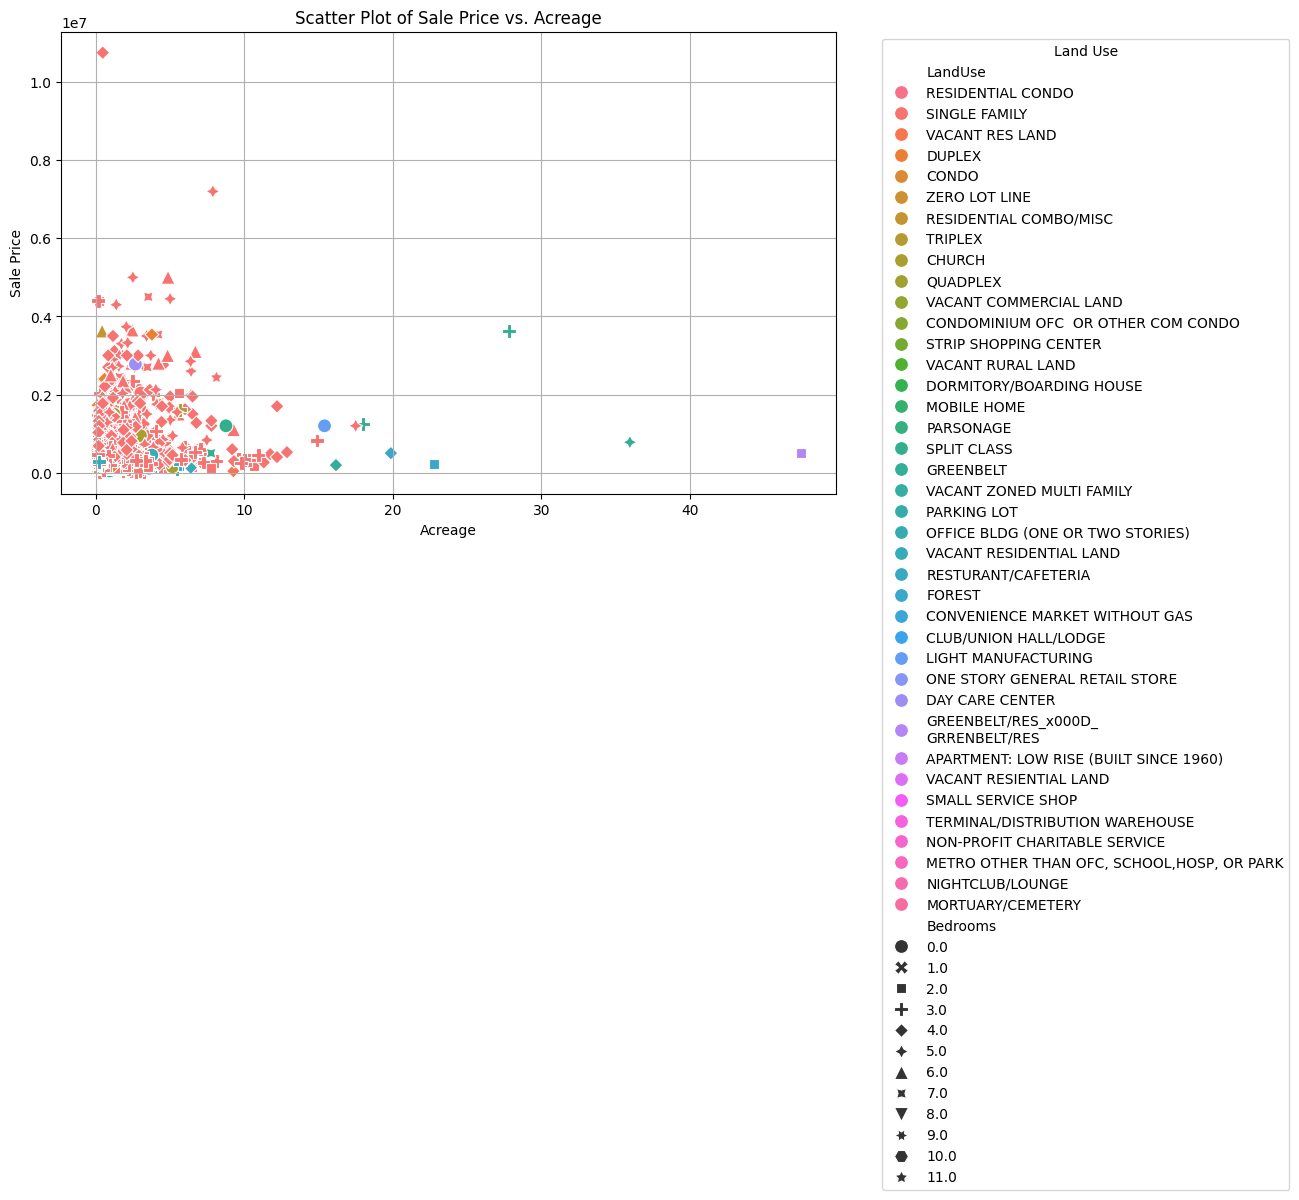

<ipython-input-16-23d49c632006>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_year, x='YearBuilt', y='SalePrice', palette='viridis')


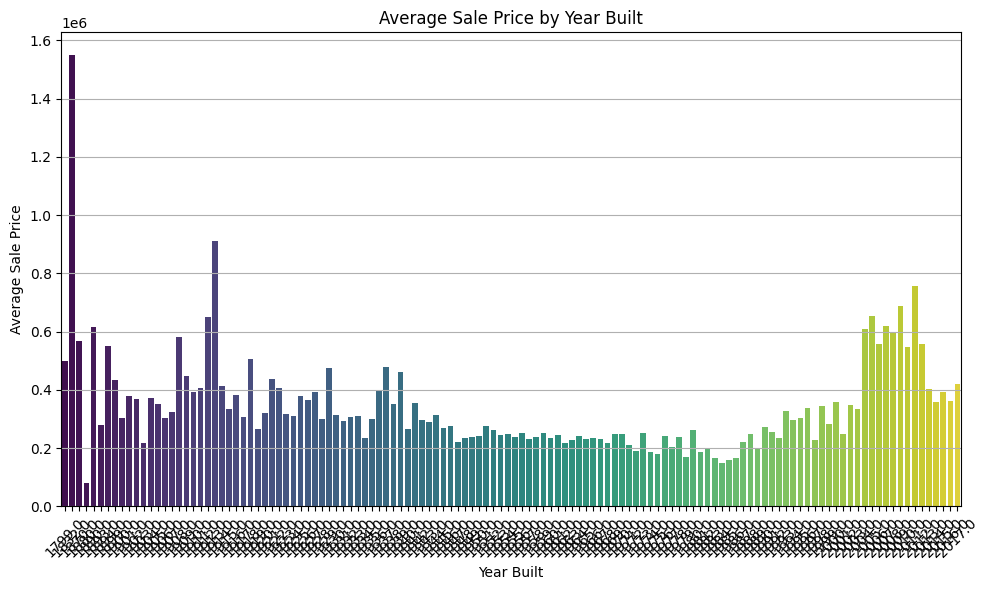

In [16]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from SQLite database
def load_data_from_sqlite(db_file):
    conn = sqlite3.connect(db_file)
    df = pd.read_sql_query("SELECT * FROM property_transactions", conn)
    conn.close()
    return df

# Main execution
if __name__ == "__main__":
    db_file = 'SQL_Data.db'  # Database file name
    df = load_data_from_sqlite(db_file)

    # Clean column names (if necessary)
    df.columns = df.columns.str.strip()

    # Scatter Plot: Sale Price vs. Acreage
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Acreage', y='SalePrice', hue='LandUse', style='Bedrooms', s=100)
    plt.title('Scatter Plot of Sale Price vs. Acreage')
    plt.xlabel('Acreage')
    plt.ylabel('Sale Price')
    plt.legend(title='Land Use', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Bar Chart: Average Sale Price by Year Built
    avg_price_by_year = df.groupby('YearBuilt')['SalePrice'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=avg_price_by_year, x='YearBuilt', y='SalePrice', palette='viridis')
    plt.title('Average Sale Price by Year Built')
    plt.xlabel('Year Built')
    plt.ylabel('Average Sale Price')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [17]:
import pandas as pd
import sqlite3

# Load data from SQLite database
def load_data_from_sqlite(db_file):
    conn = sqlite3.connect(db_file)
    df = pd.read_sql_query("SELECT * FROM property_transactions", conn)
    conn.close()
    return df

# Function to clean the data
def clean_data(df):
    # 1. Standardize Date Format
    df['SaleDate'] = pd.to_datetime(df['SaleDate'], errors='coerce')

    # 2. Populate Property Address data (fill missing addresses)
    df['PropertyAddress'] = df['PropertyAddress'].fillna(method='ffill')

    # 3. Breaking out Address into Individual Columns (Address, City, State)
    df[['PropertySplitAddress', 'PropertySplitCity']] = df['PropertyAddress'].str.split(',', expand=True)

    # 4. Change Y and N to Yes and No in "Sold as Vacant" field
    df['SoldAsVacant'] = df['SoldAsVacant'].replace({'Y': 'Yes', 'N': 'No'})

    # 5. Remove Duplicates based on specified columns
    df.drop_duplicates(subset=['ParcelID', 'PropertyAddress', 'SalePrice', 'SaleDate', 'LegalReference'], inplace=True)

    # 6. Drop unused columns (example: OwnerAddress and TaxDistrict)
    if 'OwnerAddress' in df.columns:
        df.drop(columns=['OwnerAddress', 'TaxDistrict'], inplace=True)

    return df


In [18]:

db_file = 'SQL_Data.db'  # Database file name
df = load_data_from_sqlite(db_file)

# Clean the data
cleaned_df = clean_data(df)

# Display cleaned data
print(cleaned_df.head())  # Display first few rows of the cleaned DataFrame

# Optionally save the cleaned data back to SQLite or another format
cleaned_df.to_sql('cleaned_property_transactions', sqlite3.connect(db_file), if_exists='replace', index=False)

<ipython-input-17-07f02f850166>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['PropertyAddress'] = df['PropertyAddress'].fillna(method='ffill')


   UniqueID          ParcelID            LandUse  \
0         0  105 03 0D 008.00  RESIDENTIAL CONDO   
1         1   105 11 0 080.00      SINGLE FAMILY   
2         2   118 03 0 130.00      SINGLE FAMILY   
3         3   119 01 0 479.00      SINGLE FAMILY   
4         4   119 05 0 186.00      SINGLE FAMILY   

                PropertyAddress   SaleDate  SalePrice    LegalReference  \
0    1208  3RD AVE S, NASHVILLE 2013-01-24   132000.0  20130128-0008725   
1   1802  STEWART PL, NASHVILLE 2013-01-11   191500.0  20130118-0006337   
2  2761  ROSEDALE PL, NASHVILLE 2013-01-18   202000.0  20130124-0008033   
3  224  PEACHTREE ST, NASHVILLE 2013-01-18    32000.0  20130128-0008863   
4      316  LUTIE ST, NASHVILLE 2013-01-23   102000.0  20130131-0009929   

  SoldAsVacant                      OwnerName  Acreage  LandValue  \
0           No                           None      NaN        NaN   
1           No              STINSON, LAURA M.     0.17    32000.0   
2           No               

56374